In [1]:
import numpy as np
import time
from imageio import imread
import matplotlib.pyplot as plt

from scipy.ndimage.filters import convolve 
from skimage.feature import peak_local_max, canny
from skimage.filters import threshold_otsu

In [2]:
def rank_filter(im, size, op):
    
    h, w = im.shape
    dx = dy = size // 2
    
    res = np.zeros_like(im)
    for i in range(h):
        for j in range(w):
            y0 = max(i - dy, 0)
            y1 = i + dy
            x0 = max(j - dx, 0)
            x1 = j + dx
            
            res[i, j] = op(im[y0:y1, x0:x1])
            
    
    return res

from functools import partial

min_filter = partial(rank_filter, op=np.min)
max_filter = partial(rank_filter, op=np.max)


(130, 151)


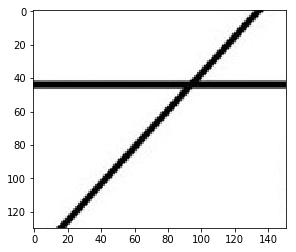

In [3]:
im = imread("../../samples/houghlines.jpg", pilmode="L")

plt.imshow(im, cmap="gray", vmin=0, vmax=255)
print(im.shape)
plt.show()

In [4]:
sobel = np.array([
    [-1,  0,  1],
    [-2,  0,  2],
    [-1,  0,  1],
]) 

# I = norm_I.astype(np.float) / 255
I = im.astype(np.float) / 255

I_x = convolve(I, sobel)
I_y = convolve(I, sobel.T)

I_grad = np.sqrt(I_x**2 + I_y**2)

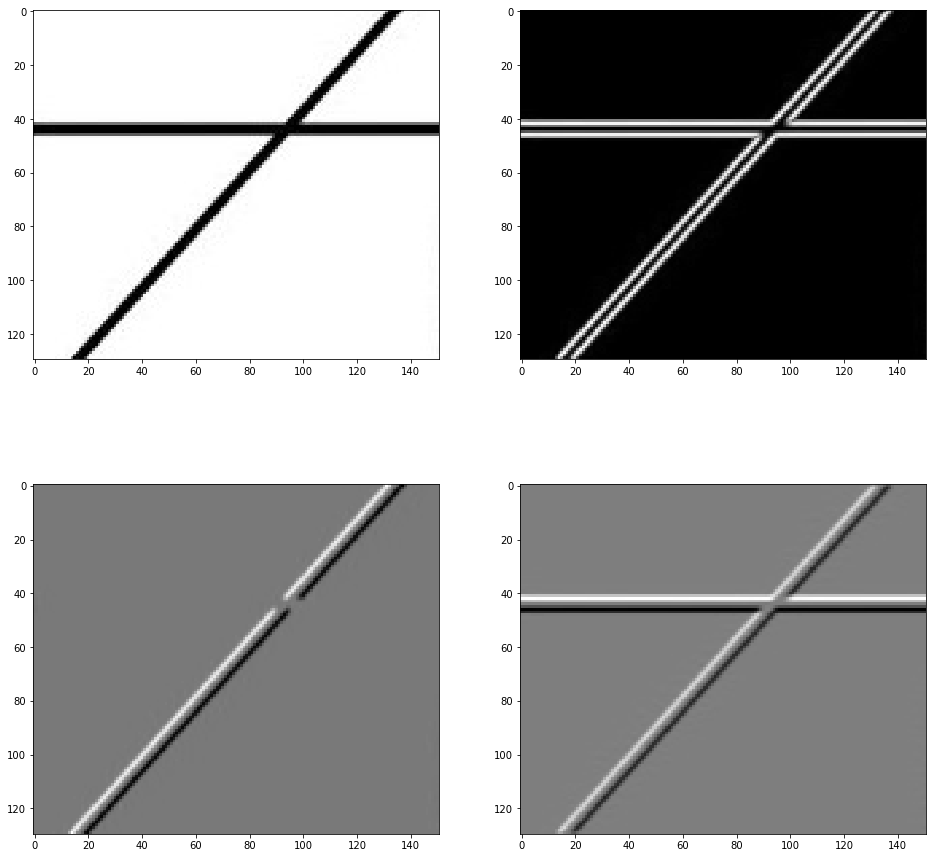

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(16,16))

axs[0,0].imshow(I, cmap=plt.cm.gray)
axs[0,1].imshow(I_grad, cmap=plt.cm.gray)
axs[1,0].imshow(I_x, cmap=plt.cm.gray)
axs[1,1].imshow(I_y, cmap=plt.cm.gray)

plt.show()
plt.close()

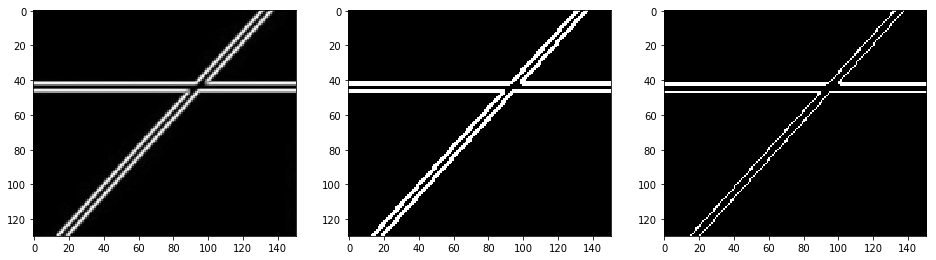

In [6]:
def thin(im, size=3):
    return min_filter(im, size=size)

thresh = threshold_otsu(I_grad)
I_binary = I_grad >= thresh

I_thin = thin(I_binary)

fig, axs = plt.subplots(1, 3, figsize=(16,9))

axs[0].imshow(I_grad, cmap=plt.cm.gray)
axs[1].imshow(I_binary, cmap=plt.cm.gray)
axs[2].imshow(I_thin, cmap=plt.cm.gray)

plt.show()

In [7]:
def detect_edges(im, size=3, thresh=0.5):
    dx = dy = int(size//2)
    
    h, w = im.shape
    
    detections = np.zeros(im.shape, np.float32)
    
    values = np.zeros((h,w, 2), np.float32)
    for i in range(h):
        for j in range(w):
            x0, x1 = max(0, j-dx), j+dx+1
            y0, y1 = max(0, i-dy), i+dy+1
            
            patch = im[y0:y1,x0:x1]
            I_x, I_y = convolve(patch, sobel), convolve(patch, sobel.T)
            
            S = np.array([
                [I_x**2, I_x*I_y], 
                [I_x*I_y, I_y**2], 
            ])
            
            S = S.mean(axis=(2,3))
            
            eigen_values, _ = np.linalg.eig(S)
            values[i,j] = eigen_values
    values /= values.max(axis=(0,1), keepdims=True)
    
    return np.logical_and(values[..., 0] > thresh, values[..., 1] > thresh)

        

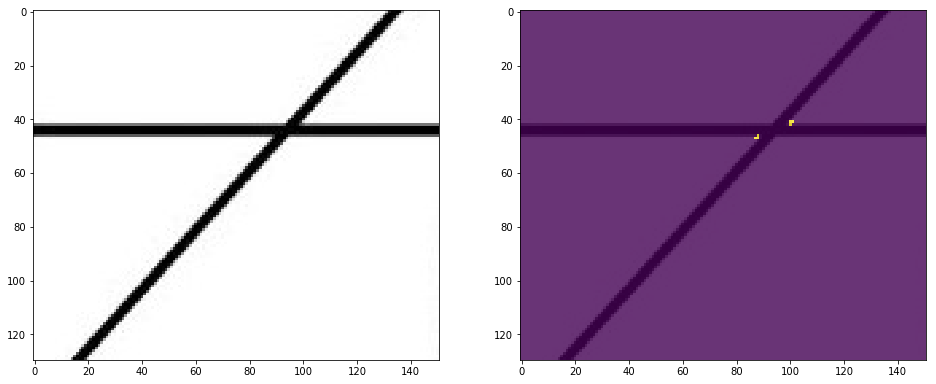

In [8]:
im = I.astype(np.float32).copy()

corners = detect_edges(im, size=3, thresh=0.1)

fig, ax = plt.subplots(1, 2, figsize=(16,9))

ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(corners, alpha=0.8)

plt.show()
plt.close()

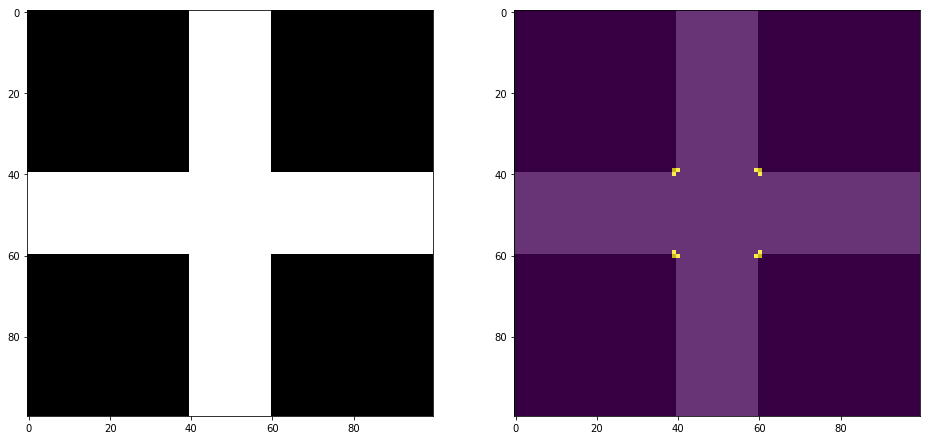

In [10]:
im = np.zeros((100, 100), np.float32)

im[40:60] = 1
im[:, 40:60] = 1

corners = detect_edges(im, size=3, thresh=0.1)

fig, ax = plt.subplots(1, 2, figsize=(16,9))

ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(corners, alpha=0.8)

plt.show()
plt.close()